## IMPORTING NECESSARY LIBRARIES

In [46]:
# These are pytorch imports for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, random_split
from sklearn.metrics import classification_report
from torchvision.transforms import ToTensor, transforms
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler
from tqdm.auto import tqdm
import os
import random
import numpy as np
from PIL import Image
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
warnings.filterwarnings("ignore")

In [47]:
# path to the dataset
root_dir =  "/kaggle/input/fruits-dataset-images/images"

### CREATING A CUSTOM DATASET CLASS

In [48]:
class CustomDataset(Dataset):
    """This takes in the file path containing the image and label folders, reads them, converts to RGB if 
    necessary, applies the defined transformations in them then returns the images and the labels and returns
    random samples for visualization."""
    def __init__(self, root_dir, transform = None, weights = None):
        self.root_dir = root_dir
        self.transform = transform
        
        self.image_paths = [str(i) for i in Path(self.root_dir).rglob("*jpg")]
        #print(self.image_paths)
        
        self.labels = [Path(i).parent.name for i in self.image_paths]
        
        
        self.classes = sorted(set(self.labels))
        #print(self.classes)
        
        self.class2idx = dict(zip(self.classes, range(len(self.classes))))
        self.labels = [self.class2idx[i] for i in self.labels]
        #print(self.labels)
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        label = self.labels[idx]
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label
    
    def get_random_sample_for_classes(self):
        samples = []
        
        for cls, _id in self.class2idx.items():
            sample_idx = self.labels.index(_id)
            samples.append({"class": cls, "img_idx":sample_idx, "img": self.image_paths[sample_idx]})
        return samples

Now we apply data augmentation using transforms. This augmentation helps to increase the dataset size and model performance.Some augmentations such as rotations and flips can help the model learn to be invariant to the transforms. We will implement the resize, rotation, horizontal and vertical flip transforms. It is important to note that the same data preprocessing stage will be applied to both models so they would have the same baseline for performance.

#### DEFINING TRANSFORMS

In [49]:
# This is the pytorch convention of data augmentation
transform = transforms.Compose(
    [
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.5, 0.5, 0.5],
        std = [0.5, 0.5, 0.5]
    ),
]
)

#### INITIALIZATIONS

In [50]:
# the random seed aids repetition and production of deterministic results 
# initialization of default training unit to CPU if GPU is not available
RANDOM_SEED = 46
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32

In [51]:
# initializing the custom dataset class to load the dataset
dataset = CustomDataset(root_dir=root_dir, transform=transform)

In [52]:
# lenght of the dataset
len(dataset)

315

### VISUALIZATION

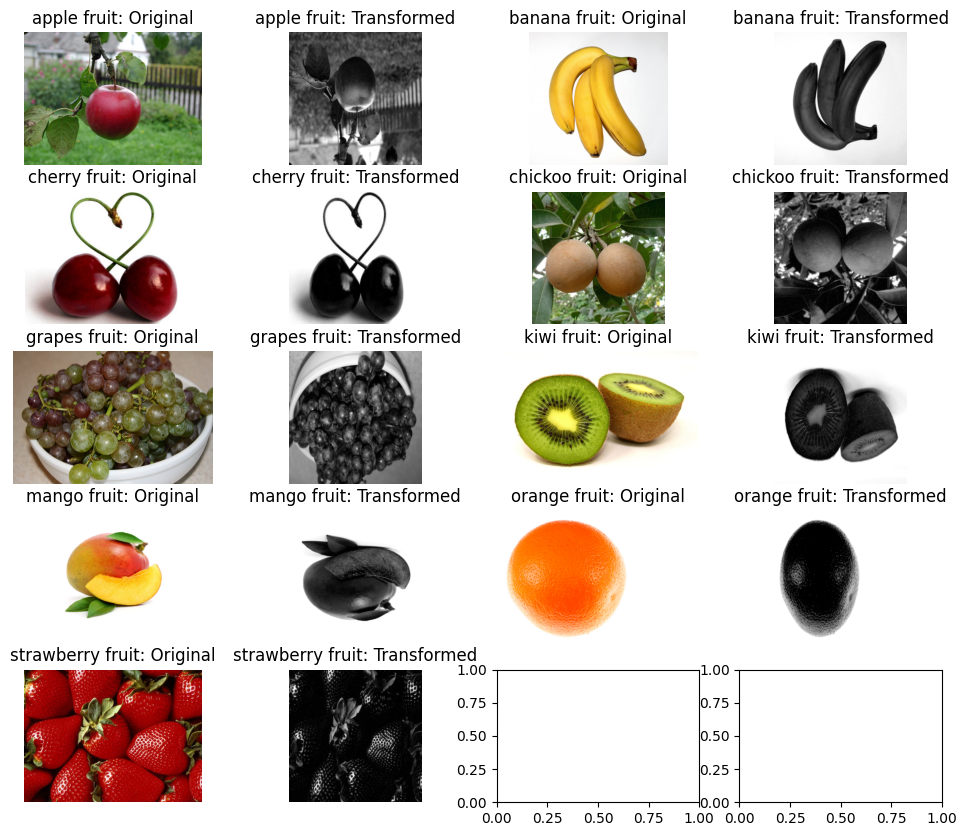

In [53]:
# visualize the images and the transformed images
n_classes = len(dataset.classes) 
grid_rows = (n_classes * 2) // 4

# Create a figure and axis for the grid of images
_, axes = plt.subplots(4 + n_classes % 4, grid_rows, figsize=(12, 10))

axes = axes.ravel()
samples = dataset.get_random_sample_for_classes()


for i in range(0, len(axes), 2):
    # Check if we have more images than subplots
    
    
    if i < len(samples) * 2:
        ax = axes[i]
        ax2 = axes[i+1]

        sample = samples[i // 2]

        ax.imshow(np.array(Image.open(sample['img'])))
        ax.set_title(f'{sample["class"]}: Original')
        ax.axis('off')


        ax2.imshow(dataset[sample['img_idx']][0][-1], cmap='gray')
        ax2.set_title(f'{sample["class"]}: Transformed')
        ax2.axis('off')

plt.tight_layout

plt.show()

#### SPLITTIING THE DATASET USING RANDOM SPLIT FOR THE DATASET INSTANCE

In [54]:
# initialize the train size to 70% of the dataset while the 30% goes for testing and validation
train_size = int(0.7 * len(dataset))
test_val_size = len(dataset) - train_size

In [55]:
# implementing the 70-30% split using random split
train_dataset, test_val_dataset = random_split(dataset, [train_size, test_val_size])

In [56]:
# split (test_val_set) to get the percentage size for test and validation dataset
test_size = test_val_size // 2
val_size = test_val_size - test_size

In [57]:
# implementing the test-val size on the remaining 30% of the dataset to get the test dataset and validation dataset using random split
test_dataset, val_dataset = random_split(test_val_dataset, [test_size, val_size])

#### DATALOADER IMPLEMENTATION

In [58]:
# pytorch dataloader implementation for the train dataloader
train_dataloader = DataLoader(train_dataset, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True,
                              )

In [59]:
# pytorch dataloader implementation for the validation dataloader
val_dataloader = DataLoader(val_dataset, 
                            batch_size=BATCH_SIZE, 
                            shuffle=False,
                            )

In [60]:
# pytorch dataloader implementation for the test dataloader
test_dataloader = DataLoader(test_dataset, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False,
                             )

In [61]:
# checking the shape
first_batch = next(iter(train_dataloader))

In [62]:
# checking the dimension of the dataloader
for batch_idx, (inputs, labels) in enumerate(train_dataloader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Input shape: {inputs.shape}, Labels shape: {labels.shape}")
    break

Batch 1:
Input shape: torch.Size([32, 3, 300, 300]), Labels shape: torch.Size([32])


In [63]:
inputs = first_batch

In [64]:
inputs[0][1].shape

torch.Size([3, 300, 300])

#### HYPERPARAMETERS

In [65]:
#number of input channels set to 3 for RGB images
in_channels = 3
#number of classes of fruit in dataset
num_classes = 9
#determines how much the model's weights are updated during each training step for resnet
learning_rate_r = 1e-5
#determines how much the model's weights are updated during each training step for cnn
learning_rate_c = 0.0003
#number of times the model was trained per cycle
NUM_EPOCHS = 20

### RESNET MODEL

In [66]:
class ResNet(nn.Module):
    """This class calls the resnet50 weight from the pytorch library for pretrained models, fine tunes it to suit
    the number of classes for our desired task then outputs the tuned model"""
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        
        #Load the pre-trained ResNet 50 model
        self.resnet = models.resnet50(pretrained=True)
        
        #allow gradient updates for all parameters in the model
        for param in self.resnet.parameters():
            param.requires_grad = True
            
        #This will get the number of input features for the final fully connected layer
        in_features = self.resnet.fc.in_features
            
        #Ths will replace the final fully connected layer with a new one
        self.resnet.fc = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        return self.resnet(x)

#### INSTANTIATE THE MODEL

In [67]:
model = ResNet(num_classes)

In [68]:
list(model.named_modules())

[('',
  ResNet(
    (resnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          

In [69]:
list(model.named_modules())[-1][1].in_features

2048

In [70]:
model.to(device)

ResNet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0

#### LOSS FUNCTION AND OPTIMIZER

In [71]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate_r)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### RESNET TRAINING

The learning rate scheduler adjusts the learning rate over time to improve the training performance

In [72]:
# The training loop is a pytorch convention, here the train and validation loaders are trained and tested using early stoppings
#Storing the loss and accuracy value for each epoch
r_train_losses = []
r_accuracy_values = []

# EARLY STOPPING PARAMETERS(Early stopping for managing overfitting)
patience = 5
best_val_loss = float("inf")
current_patience = 0

for epoch in range(NUM_EPOCHS):
    r_train_loss = 0.0
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    
    #initializing the prediction count to zero before the loop
    r_correct = 0
    r_total = 0
    for batch_idx, (inputs, labels) in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        #get data to cuda if possible
        inputs = inputs.to(device, dtype = torch.float32)
        labels = labels.to(device, dtype = torch.long) 
        
        # forward pass
        # optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        #This code accumulates training loss, stores loss values for each batch
        r_train_loss += loss.item()
        r_train_losses.append(loss.item())
        
        _, predicted = torch.max(outputs, dim=1)
        r_total += labels.size(0)
        r_correct += (predicted == labels).sum().item()
        
        #back propagation
        loss.backward()
        
        # gradient descent
        optimizer.step()
        optimizer.zero_grad()
        
    # update learning rate scheduler
    scheduler.step()
        
    epoch_loss = r_train_loss / len(train_dataloader)
    print('Epoch {} loss: {:.3f}'.format(epoch + 1, epoch_loss))
    r_train_accuracy = 100 * (r_correct / r_total)
    r_accuracy_values.append(r_train_accuracy)
    
    # validation accuracy
    model.eval()
    r_val_correct = 0
    r_val_total = 0
    r_val_losses = []
    r_accuracy_val_values = []
    
    with torch.no_grad():
        r_val_loss = 0.0
        for batch_idx, (inputs, labels) in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
            inputs = inputs.to(device, dtype = torch.float32)
            labels = labels.to(device, dtype = torch.long) 
            
            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # get loss
            r_val_loss += loss.item()
            r_val_losses.append(loss.item())
            
            # get prediction
            _, predicted = torch.max(outputs, dim=1)
            r_val_total += labels.size(0)
            r_val_correct += (predicted == labels).sum().item()
        
        # Calculate the average validation loss after the loop
        r_val_loss /= len(val_dataloader)
        
        # Check improvement
        if r_val_loss < best_val_loss:
            best_val_loss = r_val_loss
            current_patience = 0
        else:
            current_patience += 1
            
         # Print accuracy and check for early stopping
        r_val_accuracy = 100 * (r_val_correct / r_val_total)
        r_accuracy_val_values.append(r_val_accuracy)
        print(f"Epoch {epoch + 1}, Training Accuracy: {r_train_accuracy:.2f}%, Validation Accuracy: {r_val_accuracy:.2f}%, Loss: {epoch_loss:.4f}, Validation Loss: {r_val_loss:.4f}")

        # If early stopping criteria met
        if current_patience >= patience:
            print(f"Early stopping after {epoch + 1} epochs.")
            break

Epoch [1/20]


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1 loss: 2.145


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1, Training Accuracy: 14.55%, Validation Accuracy: 16.67%, Loss: 2.1449, Validation Loss: 2.0859
Epoch [2/20]


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2 loss: 1.949


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2, Training Accuracy: 48.64%, Validation Accuracy: 60.42%, Loss: 1.9488, Validation Loss: 1.8219
Epoch [3/20]


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3 loss: 1.519


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3, Training Accuracy: 75.45%, Validation Accuracy: 77.08%, Loss: 1.5190, Validation Loss: 1.3612
Epoch [4/20]


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4 loss: 0.922


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4, Training Accuracy: 84.55%, Validation Accuracy: 83.33%, Loss: 0.9216, Validation Loss: 0.7702
Epoch [5/20]


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5 loss: 0.390


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5, Training Accuracy: 93.64%, Validation Accuracy: 83.33%, Loss: 0.3897, Validation Loss: 0.5963
Epoch [6/20]


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6 loss: 0.176


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6, Training Accuracy: 95.00%, Validation Accuracy: 89.58%, Loss: 0.1757, Validation Loss: 0.7168
Epoch [7/20]


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7 loss: 0.116


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7, Training Accuracy: 95.91%, Validation Accuracy: 87.50%, Loss: 0.1159, Validation Loss: 0.6313
Epoch [8/20]


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8 loss: 0.054


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8, Training Accuracy: 98.18%, Validation Accuracy: 89.58%, Loss: 0.0536, Validation Loss: 0.6478
Epoch [9/20]


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9 loss: 0.038


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9, Training Accuracy: 99.55%, Validation Accuracy: 89.58%, Loss: 0.0385, Validation Loss: 0.6938
Epoch [10/20]


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10 loss: 0.030


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10, Training Accuracy: 99.55%, Validation Accuracy: 89.58%, Loss: 0.0297, Validation Loss: 0.7024
Early stopping after 10 epochs.


### RESNET TESTING

In [73]:
# this is the pytorch testing loop convention
# initialize the total sample count and correct prediction count to zero
r_correct_pred = 0.0
r_total_samples = 0.0
# storing all the loss, predictions and label values for the test
r_test_losses = []
r_all_predictions = []
r_all_labels = []

model.eval()
with torch.no_grad():
    r_test_loss = 0.0
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device, dtype = torch.float32)
        labels = labels.to(device, dtype = torch.long)
        
        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # get loss
        r_test_loss += loss.item()
        #r_test_losses.append(r_test_loss)
        r_test_losses.append(loss.item())

        # get prediction
        _, predicted = torch.max(outputs, dim=1)
        r_total_samples += labels.size(0)

        # calculate accuracy
        r_correct_pred += (predicted == labels).sum()

        # get predicted and actual labels
        r_all_predictions.extend(predicted.cpu().numpy())
        r_all_labels.extend(labels.cpu().numpy())

r_test_loss /= len(test_dataloader.dataset)
accuracy = r_correct_pred / r_total_samples

# view loss and accuracy
print("Test Loss: {:.3f} | Accuracy: {:.3f}".format(r_test_loss, accuracy))

Test Loss: 0.007 | Accuracy: 0.936


#### SAVE AND LOAD MODEL

In [74]:
# CREATING A DIRECTORY USING THE PATH AND FILENAME OF THE MODEL
dir = "saved_model"
model_filename = "Resnet_checkpoint_FC.pth.tar"

In [75]:
# save model and optimizer states
def save_model(model, optimizer, dir = dir, filename = model_filename):
    """takes in the model name and optimizer, the directory and the filename"""
    # joining the filepath using the os library
    path = os.path.join(dir, filename)
    state = {
        "model_state":model.state_dict(),
        "optimizer_state":optimizer.state_dict(),
    }
    torch.save(state, path)
    print("model saved successfully ")
    
def load_model(checkpoint, model, optimizer, lr):
    """takes the checkpoint already created, the model and optimizer and initializes an already made model"""
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
        
    return model

### CHECKING OTHER EVALUATION METRICS FOR RESNET

In [76]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

In [77]:
# these are gotten from the sklearn library
accuracy = accuracy_score(r_all_labels, r_all_predictions)
precision = precision_score(r_all_labels, r_all_predictions, average = "weighted")
recall = recall_score(r_all_labels, r_all_predictions, average = "weighted")
f1 = f1_score(r_all_labels, r_all_predictions, average = "weighted")

#### RESNET RESULTS

In [78]:
print(f"Accuracy: {accuracy:.3f}, precision: {precision:.3f}, recall: {recall:.3f}, F1: {f1:.3f}")

Accuracy: 0.936, precision: 0.940, recall: 0.936, F1: 0.936


#### RESNET CLASSIFICATION REPORT

In [79]:
report = classification_report(r_all_labels, r_all_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       1.00      1.00      1.00         7
           2       0.75      0.75      0.75         4
           3       1.00      1.00      1.00         3
           4       0.80      1.00      0.89         4
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00         5
           7       1.00      0.80      0.89         5
           8       1.00      1.00      1.00         6

    accuracy                           0.94        47
   macro avg       0.93      0.93      0.93        47
weighted avg       0.94      0.94      0.94        47



#### RESNET VISUALIZATIONS

#### CONFUSION MATRIX

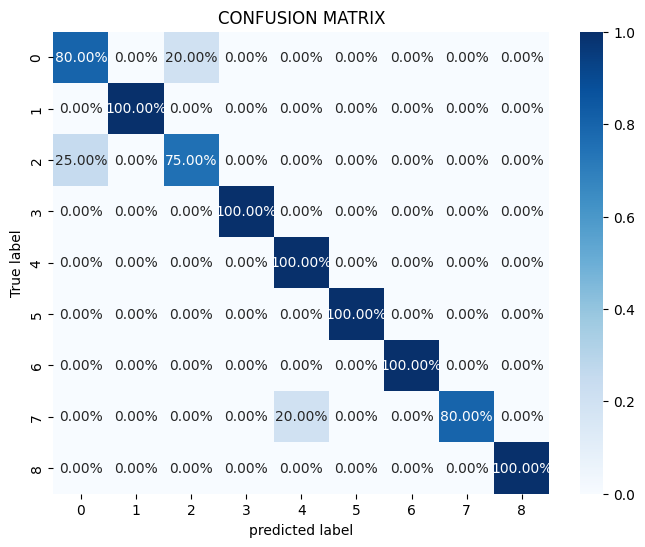

In [80]:
c_matrix = confusion_matrix(r_all_labels, r_all_predictions)
c_matrix_percentage = c_matrix.astype("float") / c_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(c_matrix_percentage, annot=True, cmap="Blues", fmt=".2%", cbar=True)
plt.title("CONFUSION MATRIX")
plt.ylabel("True label")
plt.xlabel("predicted label")
plt.show()

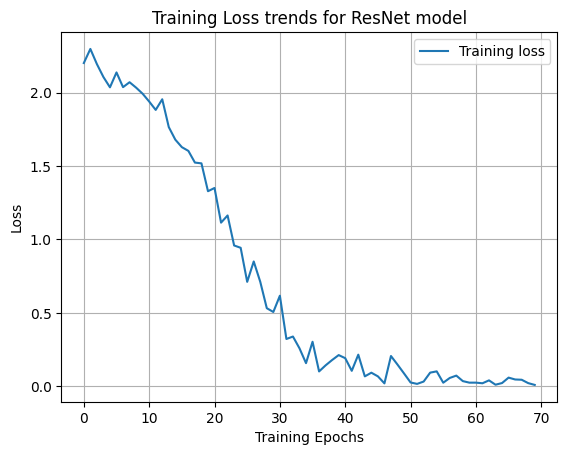

In [81]:
# plot loss progress
plt.title("Training Loss trends for ResNet model")
plt.plot(r_train_losses, label = "Training loss")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.grid(True)
plt.show()

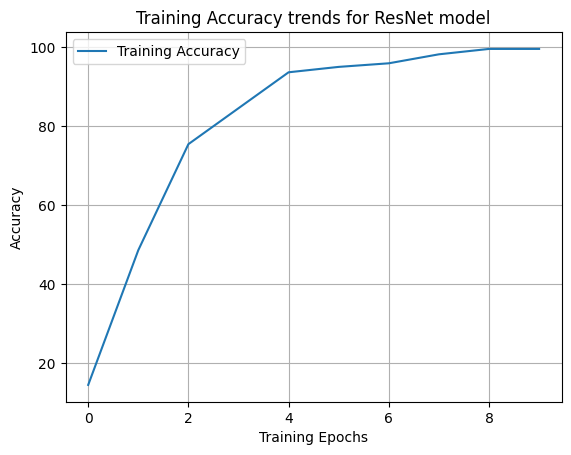

In [82]:
# plot accuracy progress
plt.title("Training Accuracy trends for ResNet model")
plt.plot(r_accuracy_values, label = "Training Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.grid(True)
plt.show()

### CUSTOM CONVOLUTION NEURAL NETWORK MODEL

In [83]:
class ConvolutionNeuralNetwork(nn.Module):
    def __init__(self, in_channels = None,out_channels = None):
        super(ConvolutionNeuralNetwork, self). __init__()
        # input channel of 3 because it is a coloured image dataset
        # kernel size, stride and padding are parameters that can be changed but following a 3x3 kernel with same stride and padding
        # this is a convolution layer
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32))
        
        # convolution layer
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False))
        
        # adding a convolution pooling layer
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # convolution layer
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64))
        
        # activation function layer to add non linearity
        self.relu = nn.ReLU()
       
        # convolutional pooling layer
        self.avgpool = nn.AvgPool2d(7)
        # regulariration dropout 
        self.dropout = nn.Dropout(0.5)
        
        # fully connected layer
        self.fc1 = nn.Linear(64 * 21 * 21, num_classes)
        
    def forward(self, x):
        x = F.relu(self.layer1(x)) 
        x = self.pool1(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.avgpool(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

#### INSTANTIATE THE MODEL

In [84]:
model2 = ConvolutionNeuralNetwork()

In [85]:
model2.to(device)

ConvolutionNeuralNetwork(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU()
  (avgpool): AvgPool2d(kernel_size=7, stride=7, padding=0)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=28224, out_features=9, bias=True)
)

#### LOSS FUNCTION AND OPTIMIZER FOR CNN

In [86]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=learning_rate_c)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### CNN TRAINING

In [87]:
# The training loop is a pytorch convention, here the train and validation set are trained and tested using early stoppings
#Storing the loss and accuracy value for each epoch
c_train_losses = []
c_accuracy_values = []

# EARLY STOPPING PARAMETERS(Early stopping for managing overfitting)
patience = 5
best_val_loss = float("inf")
current_patience = 0

for epoch in range(NUM_EPOCHS):
    c_train_loss = 0.0
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    
    #initializing the prediction count to zero before the loop
    c_correct = 0
    c_total = 0
    for batch_idx, (inputs, labels) in tqdm(enumerate(train_dataloader), total = len(train_dataloader)):
        #get data to cuda if possible
        inputs = inputs.to(device, dtype = torch.float32)
        labels = labels.to(device, dtype = torch.long) 
        
        # forward pass
        # optimizer.zero_grad()
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        
        # get losses
        c_train_loss += loss.item()
        c_train_losses.append(loss.item())
        
        _, predicted = torch.max(outputs, dim=1)
        c_total += labels.size(0)
        c_correct += (predicted == labels).sum().item()
        
        #back propagation
        loss.backward()
        
        # gradient descent
        optimizer.step()
        optimizer.zero_grad()
        
    # update learning rate scheduler
    scheduler.step()
        
    epoch_loss = c_train_loss / len(train_dataloader)
    print('Epoch {} loss: {:.3f}'.format(epoch + 1, epoch_loss))
    c_train_accuracy = 100 * (c_correct / c_total)
    c_accuracy_values.append(c_train_accuracy)
    
    # validation accuracy
    model2.eval()
    c_val_correct = 0
    c_val_total = 0
    c_val_losses = []
    c_accuracy_val_values = []
    
    with torch.no_grad():
        c_val_loss = 0.0
        for batch_idx, (inputs, labels) in tqdm(enumerate(val_dataloader), total = len(val_dataloader)):
            inputs = inputs.to(device, dtype = torch.float32)
            labels = labels.to(device, dtype = torch.long) 
            
            # forward pass
            outputs = model2(inputs)
            loss = criterion(outputs, labels)
            
            #get losses
            c_val_loss += loss.item()
            c_val_losses.append(loss.item())
            
            # get prediction
            _, predicted = torch.max(outputs, dim=1)
            c_val_total += labels.size(0)
            c_val_correct += (predicted == labels).sum().item()
        
        # Calculate the average validation loss after the loop
        c_val_loss /= len(val_dataloader)
        
        # Check improvement
        if c_val_loss < best_val_loss:
            best_val_loss = c_val_loss
            current_patience = 0
        else:
            current_patience += 1
            
         # Print accuracy and check for early stopping
        c_val_accuracy = 100 * (c_val_correct / c_val_total)
        c_accuracy_val_values.append(c_val_accuracy)
        print(f"Epoch {epoch + 1}, Training Accuracy: {c_train_accuracy:.2f}%, Validation Accuracy: {c_val_accuracy:.2f}%, Loss: {epoch_loss:.4f}, Validation Loss: {c_val_loss:.4f}")

        # If early stopping criteria met
        if current_patience >= patience:
            print(f"Early stopping after {epoch + 1} epochs.")
            break

Epoch [1/20]


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 1 loss: 2.147


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1, Training Accuracy: 25.91%, Validation Accuracy: 35.42%, Loss: 2.1474, Validation Loss: 2.0259
Epoch [2/20]


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 2 loss: 2.055


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2, Training Accuracy: 20.45%, Validation Accuracy: 35.42%, Loss: 2.0550, Validation Loss: 1.8683
Epoch [3/20]


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 3 loss: 1.911


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3, Training Accuracy: 28.64%, Validation Accuracy: 45.83%, Loss: 1.9112, Validation Loss: 1.7193
Epoch [4/20]


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 4 loss: 1.719


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4, Training Accuracy: 41.36%, Validation Accuracy: 54.17%, Loss: 1.7188, Validation Loss: 1.5738
Epoch [5/20]


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 5 loss: 1.498


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5, Training Accuracy: 54.09%, Validation Accuracy: 47.92%, Loss: 1.4981, Validation Loss: 1.4836
Epoch [6/20]


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 6 loss: 1.363


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6, Training Accuracy: 51.36%, Validation Accuracy: 45.83%, Loss: 1.3630, Validation Loss: 1.3512
Epoch [7/20]


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 7 loss: 1.250


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7, Training Accuracy: 53.64%, Validation Accuracy: 60.42%, Loss: 1.2503, Validation Loss: 1.2674
Epoch [8/20]


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 8 loss: 1.134


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8, Training Accuracy: 61.82%, Validation Accuracy: 62.50%, Loss: 1.1342, Validation Loss: 1.2517
Epoch [9/20]


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 9 loss: 1.140


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9, Training Accuracy: 61.82%, Validation Accuracy: 58.33%, Loss: 1.1400, Validation Loss: 1.2598
Epoch [10/20]


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 10 loss: 1.117


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10, Training Accuracy: 65.45%, Validation Accuracy: 60.42%, Loss: 1.1174, Validation Loss: 1.2793
Epoch [11/20]


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 11 loss: 1.102


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11, Training Accuracy: 64.09%, Validation Accuracy: 54.17%, Loss: 1.1019, Validation Loss: 1.2730
Epoch [12/20]


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 12 loss: 1.076


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12, Training Accuracy: 66.36%, Validation Accuracy: 58.33%, Loss: 1.0761, Validation Loss: 1.2766
Epoch [13/20]


  0%|          | 0/7 [00:00<?, ?it/s]

Epoch 13 loss: 1.098


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13, Training Accuracy: 63.18%, Validation Accuracy: 52.08%, Loss: 1.0978, Validation Loss: 1.2996
Early stopping after 13 epochs.


### CNN TESTING

In [88]:
# this is the pytorch testing loop convention
c_correct_pred = 0.0
c_total_samples = 0.0
c_test_losses = []
c_all_predictions = []
c_all_labels = []

model2.eval()
with torch.no_grad():
    c_test_loss = 0.0
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device, dtype = torch.float32)
        labels = labels.to(device, dtype = torch.long)
        
        # forward pass
        outputs = model2(inputs)
        loss = criterion(outputs, labels)

        # get loss
        c_test_loss += loss.item()
        #c_test_losses.append(c_test_loss)
        c_test_losses.append(loss.item())

        # get prediction
        _, predicted = torch.max(outputs, dim=1)
        c_total_samples += labels.size(0)

        # calculate accuracy
        c_correct_pred += (predicted == labels).sum()

        # get predicted and actual labels
        c_all_predictions.extend(predicted.cpu().numpy())
        c_all_labels.extend(labels.cpu().numpy())

c_test_loss /= len(test_dataloader.dataset)
accuracy = c_correct_pred / c_total_samples

# view loss and accuracy
print("Test Loss: {:.3f} | Accuracy: {:.3f}".format(c_test_loss, accuracy))

Test Loss: 0.061 | Accuracy: 0.511


### CHECKING OTHER EVALUATION METRICS FOR CNN

In [89]:
# these are gotten from the sklearn library
accuracy = accuracy_score(c_all_labels, c_all_predictions)
precision = precision_score(c_all_labels, c_all_predictions, average = "weighted")
recall = recall_score(c_all_labels, c_all_predictions, average = "weighted")
f1 = f1_score(c_all_labels, c_all_predictions, average = "weighted")

#### CNN RESULTS

In [90]:
print(f"Accuracy: {accuracy:.3f}, precision: {precision:.3f}, recall: {recall:.3f}, F1: {f1:.3f}")

Accuracy: 0.511, precision: 0.487, recall: 0.511, F1: 0.484


#### CNN CLASSIFICATION REPORT

In [91]:
report = classification_report(c_all_labels, c_all_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.20      0.20      0.20         5
           1       1.00      0.86      0.92         7
           2       0.00      0.00      0.00         4
           3       0.20      0.33      0.25         3
           4       0.44      1.00      0.62         4
           5       1.00      1.00      1.00         8
           6       0.00      0.00      0.00         5
           7       0.50      0.60      0.55         5
           8       0.33      0.17      0.22         6

    accuracy                           0.51        47
   macro avg       0.41      0.46      0.42        47
weighted avg       0.49      0.51      0.48        47



#### CNN VISUALIZATIONS

#### CONFUSION MATRIX

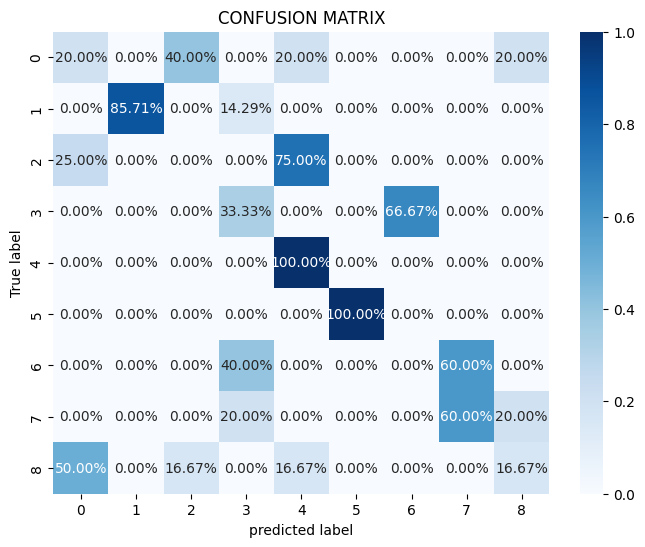

In [95]:
c_matrix = confusion_matrix(c_all_labels, c_all_predictions)
c_matrix_percentage = c_matrix.astype("float") / c_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(c_matrix_percentage, annot=True, cmap="Blues", fmt=".2%", cbar=True)
plt.title("CONFUSION MATRIX")
plt.ylabel("True label")
plt.xlabel("predicted label")
plt.show()

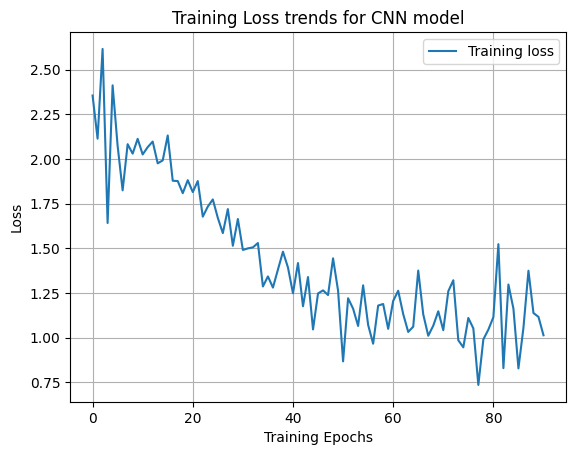

In [99]:
# plot loss progress
plt.title("Training Loss trends for CNN model")
plt.plot(c_train_losses, label = "Training loss")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.grid(True)
plt.show()

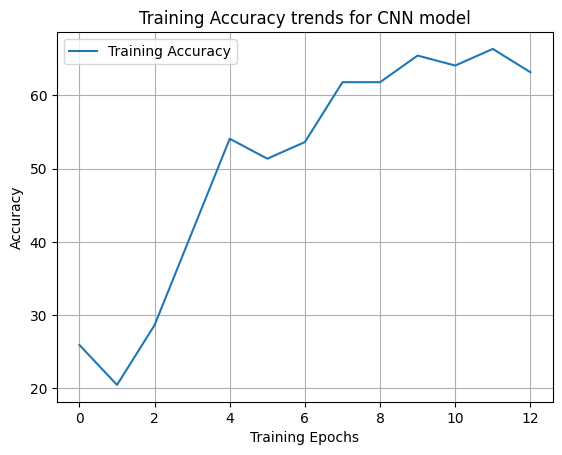

In [101]:
# plot accuracy progress
plt.title("Training Accuracy trends for CNN model")
plt.plot(c_accuracy_values, label = "Training Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.grid(True)
plt.show()